In [ ]:
from google.colab import drive
drive.mount('/content/Drive')

In [ ]:
#This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/Drive/MyDrive/SpeechMaster_Research/Models'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/content/Drive/MyDrive/SpeechMaster_Research/Models/emotion_lts.h5


In [ ]:
pip install scikit-plot

In [ ]:
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

In [ ]:
df = pd.read_csv('/content/Drive/MyDrive/SpeechMaster_Research/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [ ]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [ ]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


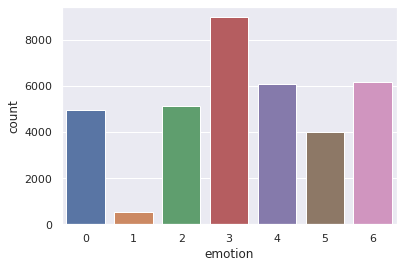

In [ ]:
sns.countplot(df.emotion)
pyplot.show()

In [ ]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

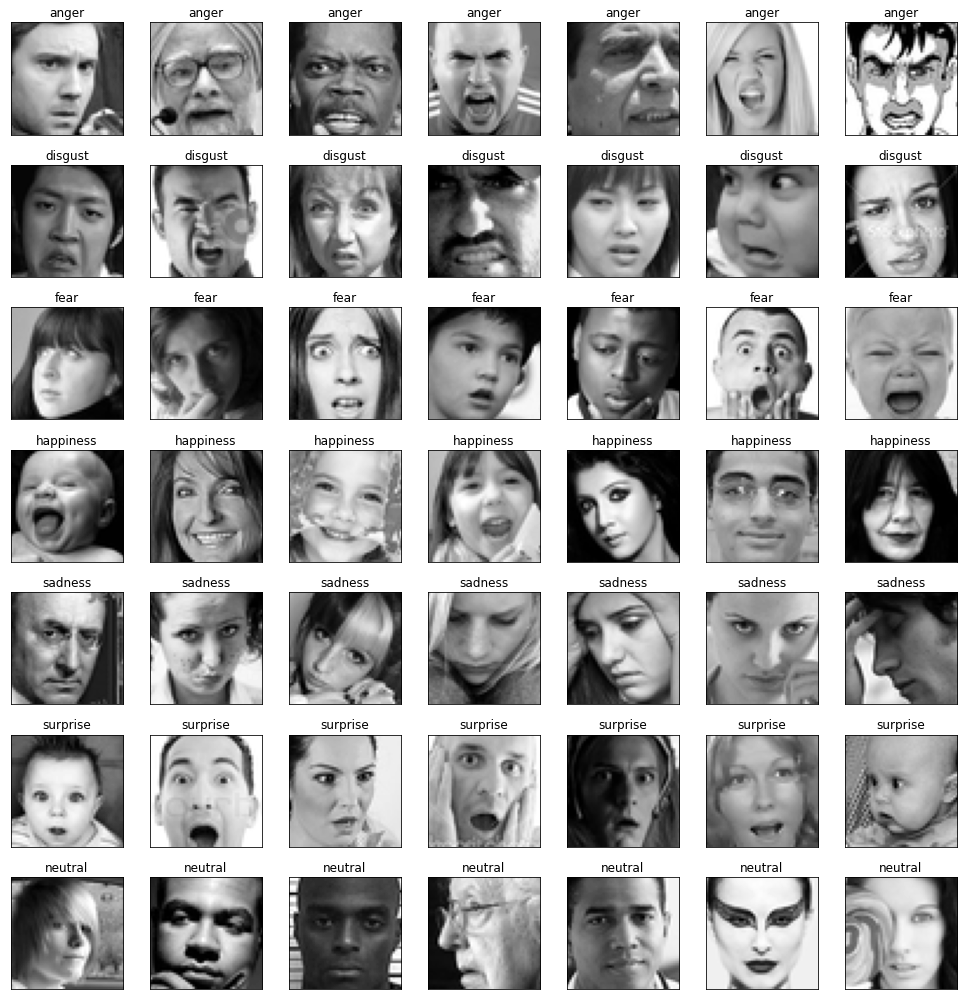

In [ ]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [ ]:
INTERESTED_LABELS = [0, 3, 4, 6]

In [ ]:
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape

(26217, 3)

In [ ]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [ ]:
img_array.shape

(26217, 48, 48, 1)

In [ ]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(26217, 4)

In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 3: 1, 4: 2, 6: 3}


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((23595, 48, 48, 1), (2622, 48, 48, 1), (23595, 4), (2622, 4))

In [ ]:
del df
del img_array
del img_labels

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [ ]:
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [ ]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [ ]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [ ]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

Training model **fer2013**

In [ ]:
# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model = build_net(optims[1]) 
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


737/737 [==============================] - 19s 24ms/step - loss: 1.5628 - accuracy: 0.3208 - val_loss: 1.2854 - val_accuracy: 0.4207
Epoch 2/100
737/737 [==============================] - 17s 24ms/step - loss: 1.3064 - accuracy: 0.3950 - val_loss: 1.1875 - val_accuracy: 0.4756
Epoch 3/100
737/737 [==============================] - 17s 23ms/step - loss: 1.2050 - accuracy: 0.4580 - val_loss: 1.1213 - val_accuracy: 0.5080
Epoch 4/100
737/737 [==============================] - 17s 23ms/step - loss: 1.0934 - accuracy: 0.5182 - val_loss: 0.9621 - val_accuracy: 0.5923
Epoch 5/100
737/737 [==============================] - 18s 24ms/step - loss: 1.0232 - accuracy: 0.5597 - val_loss: 0.9046 - val_accuracy: 0.6076
Epoch 6/100
737/737 [==============================] - 17s 24ms/step - loss: 0.9670 - accuracy: 0.5870 - val_loss: 0.8423 - val_accuracy: 0.6594
Epoch 7/100
737/737 [==============================] - 18s 24ms/step - loss: 0.9297 - accuracy: 0.6098 - val_loss: 0.8399 - val_accuracy: 0.64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

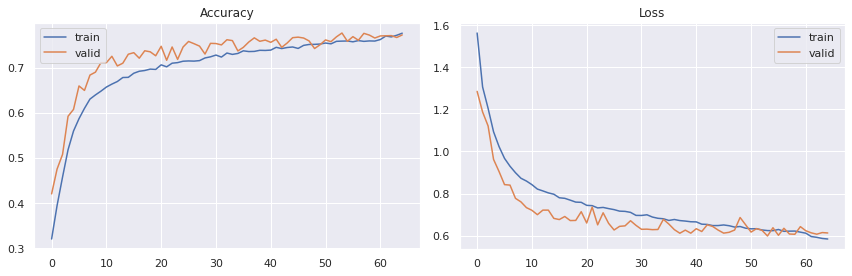

In [ ]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

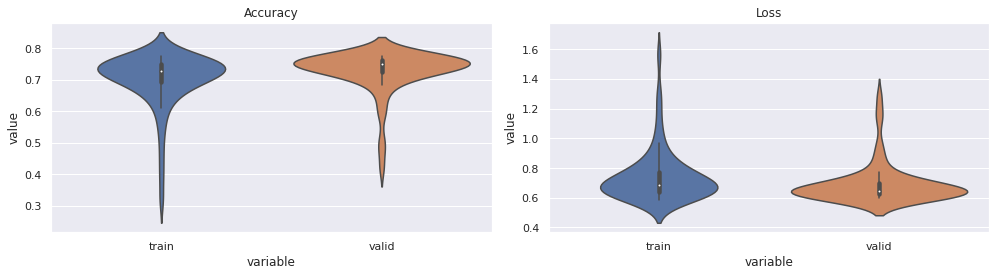

In [ ]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


total wrong validation predictions: 586


              precision    recall  f1-score   support

           0       0.75      0.68      0.71       495
           1       0.93      0.90      0.92       899
           2       0.74      0.65      0.69       608
           3       0.64      0.80      0.71       620

    accuracy                           0.78      2622
   macro avg       0.77      0.76      0.76      2622
weighted avg       0.78      0.78      0.78      2622



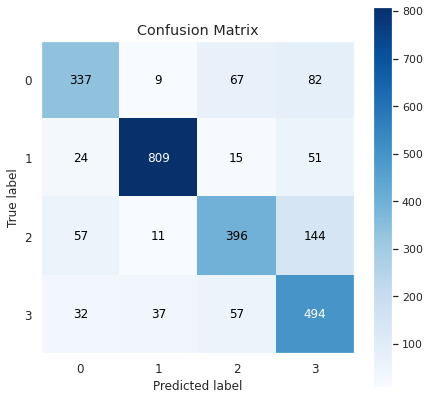

In [ ]:
yhat_valid = model.predict_classes(X_valid)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

In [ ]:
import os

model_name = 'emotion_lts.h5'
save_dir = '/content/Drive/MyDrive/SpeechMaster_Research/Models'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/Drive/MyDrive/SpeechMaster_Research/Models/emotion_lts.h5 


In [ ]:
import keras

Savedmodel = keras.models.load_model('/content/Drive/MyDrive/SpeechMaster_Research/Models/emotion_lts.h5')
Savedmodel.summary()

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856  

In [ ]:
mapper = {
    0: "Angry",
    1: "Happy",
    2: "Sad",
    3: "Neutral",
}

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


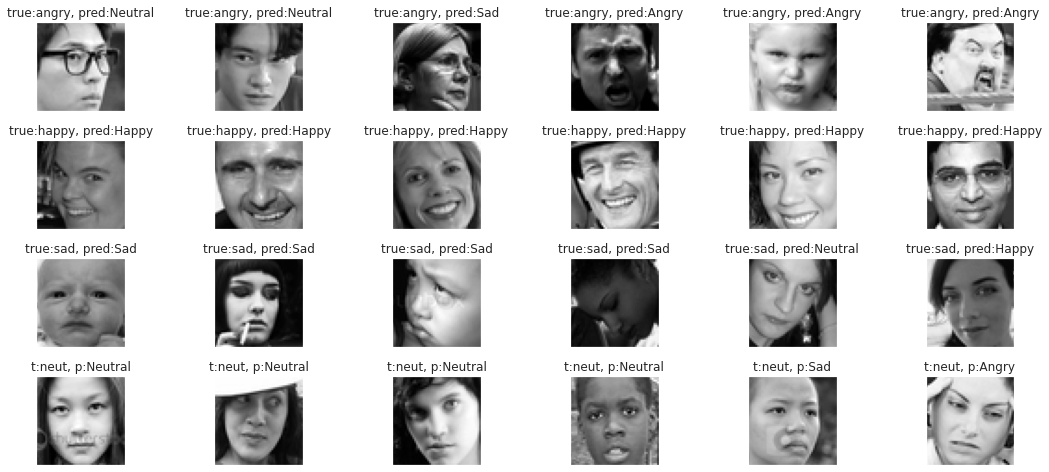

In [ ]:
import numpy as np

np.random.seed(0)
random_angry_imgs = np.random.choice(np.where(y_valid[:, 0]==1)[0], size=6)
random_happy_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=6)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=6)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 3]==1)[0], size=6)

fig = pyplot.figure(figsize=(15, 10))

for i, (angidx, hapidx, sadidx, neuidx) in enumerate(zip(random_angry_imgs, random_happy_imgs, random_sad_imgs, random_neutral_imgs)):

        ax = pyplot.subplot(6, 6, i+1)
        sample_img = X_valid[angidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:angry, pred:{mapper[Savedmodel.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

        ax = pyplot.subplot(6, 6, i+7)
        sample_img = X_valid[hapidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:happy, pred:{mapper[Savedmodel.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

        ax = pyplot.subplot(6, 6, i+13)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:sad, pred:{mapper[Savedmodel.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

        ax = pyplot.subplot(6, 6, i+19)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:neut, p:{mapper[Savedmodel.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

        pyplot.tight_layout()

In [ ]:
import matplotlib.pyplot as plt
def emotion_analysis(emotions):
    objects = ['Angry','Happy', 'Sad', 'Neutral']
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, emotions, align='center', alpha=0.9)
    plt.tick_params(axis='x', which='both', pad=10,width=4,length=10)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
plt.show()

In [ ]:
objects = ('Angry', 'Happy', 'Sad', 'Neutral')
y_pos = np.arange(len(objects))
print(y_pos)

[0 1 2 3]


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


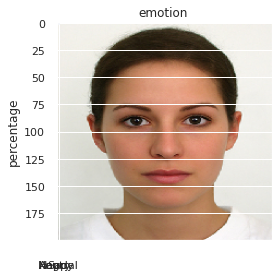

Expression Prediction: Neutral


In [ ]:
from skimage import io
from keras.preprocessing import image

img = image.load_img('/content/Drive/MyDrive/SpeechMaster_Research/img/netural.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('/content/Drive/MyDrive/SpeechMaster_Research/img/netural.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


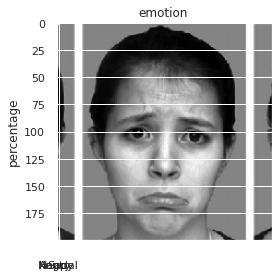

Expression Prediction: Sad


In [45]:
from skimage import io
from keras.preprocessing import image

img = image.load_img('/content/Drive/MyDrive/SpeechMaster_Research/img/t1.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('/content/Drive/MyDrive/SpeechMaster_Research/img/t1.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


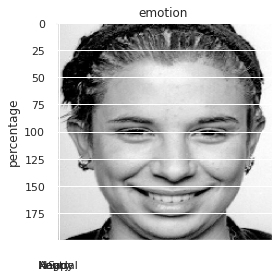

Expression Prediction: Happy


In [44]:
from skimage import io
from keras.preprocessing import image

img = image.load_img('/content/Drive/MyDrive/SpeechMaster_Research/img/t4.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('/content/Drive/MyDrive/SpeechMaster_Research/img/t4.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])

Speech Video analze

In [ ]:
from skimage import io
import os
import cv2
import numpy as np

imgdir='/content/Drive/MyDrive/SpeechMaster_Research/speechVideo/'
cap = cv2.VideoCapture('/content/Drive/MyDrive/SpeechMaster_Research/speechVideo/speech.mp4')

while(cap.isOpened()):
  ret,frame=cap.read()
  # img = image.load_img(frame,grayscale=True, target_size=(48, 48))
  frame = cv2.resize(frame,(48,48))
  frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
  x = image.img_to_array(frame)
  x = np.expand_dims(x, axis = 0)

  x /= 255

  custom = model.predict(x)
  #print(custom[0])
  emotion_analysis(custom[0])

  x = np.array(x, 'float32')
  x = x.reshape([48, 48]);


  m=0.000000000000000000001
  a=custom[0]
  for i in range(0,len(a)):
      if a[i]>m:
          m=a[i]
          ind=i

  print('Expression Prediction:',objects[ind])

  if cv2.waitKey(20) & 0XFF == ord('q'):
    break


cap.release()
cv2.destroyAllWindows()

# fileList = os.listdir(imgdir)
# for name in fileList:
#   # print(name)

#   show_img = image.load_img(imgdir+name ,grayscale=True, target_size=(48, 48))
  





Expression Prediction: Angry
Expression Prediction: Angry
Expression Prediction: Angry
Expression Prediction: Angry
Expression Prediction: Angry
Expression Prediction: Angry
Expression Prediction: Angry
Expression Prediction: Angry
Expression Prediction: Angry
Expression Prediction: Angry
Expression Prediction: Angry
Expression Prediction: Angry
Expression Prediction: Angry
Expression Prediction: Angry
Expression Prediction: Angry
Expression Prediction: Angry
Expression Prediction: Angry
Expression Prediction: Angry
Expression Prediction: Angry
Expression Prediction: Angry
Expression Prediction: Angry
Expression Prediction: Angry
Expression Prediction: Angry
Expression Prediction: Angry
Expression Prediction: Angry
Expression Prediction: Angry
Expression Prediction: Angry
Expression Prediction: Angry
Expression Prediction: Angry
Expression Prediction: Angry
Expression Prediction: Angry
Expression Prediction: Angry
Expression Prediction: Angry
Expression Prediction: Angry
Expression Pre

error: ignored

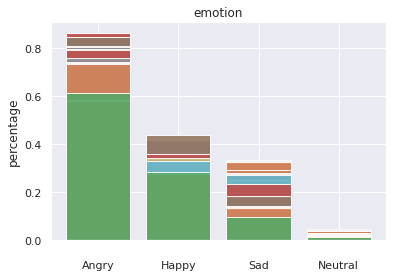

In [42]:
from skimage import io
import os
import cv2
import numpy as np

imgdir='/content/Drive/MyDrive/SpeechMaster_Research/speechVideo/'
cap = cv2.VideoCapture('/content/Drive/MyDrive/SpeechMaster_Research/speechVideo/v3.mp4')

while(cap.isOpened()):
  ret,frame=cap.read()
  # img = image.load_img(frame,grayscale=True, target_size=(48, 48))
  frame = cv2.resize(frame,(48,48))
  frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
  x = image.img_to_array(frame)
  x = np.expand_dims(x, axis = 0)

  x /= 255

  custom = model.predict(x)
  #print(custom[0])
  emotion_analysis(custom[0])

  x = np.array(x, 'float32')
  x = x.reshape([48, 48]);


  m=0.000000000000000000001
  a=custom[0]
  for i in range(0,len(a)):
      if a[i]>m:
          m=a[i]
          ind=i

  print('Expression Prediction:',objects[ind])

  if cv2.waitKey(20) & 0XFF == ord('q'):
    break


cap.release()
cv2.destroyAllWindows()
